In [41]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
from qutip import *
import matplotlib.gridspec as gridspec
from scipy.integrate import trapezoid
from qutip import wigner
from tqdm.auto import tqdm

In [60]:
N = 30 #Hilbert space cutoff per mode

cat_state = (coherent(N,alpha=1) - coherent(N,alpha=-1)).unit()

sq = squeeze(N, z = np.log(1.2))

cat_state_squeezed = (sq * cat_state).unit()

x = np.linspace(-5, 5, 100)

p = np.linspace(-5, 5, 100)

cat_W = wigner(cat_state_squeezed, x, p)

# vi behøves ikke at have density matrices fordi vi har ikke losses med endnu, så derfor kan cat bare være en ket state.

$|CAT\rangle_{1} \otimes |CAT\rangle_{2}$

In [43]:
two_mode_cat_begin = tensor(cat_state_squeezed, cat_state_squeezed)


$BS(\theta) |CAT\rangle_{1} \otimes |CAT\rangle_{2}$

In [44]:
def BS(T, N1, N2, input_state):
    """
    Beam splitter operator with transmissivity eta.
    Works on density matrices only.
    """

    a1, a2 = destroy(N1), destroy(N2)

    # angle from transmissivity
    eta = 1/T
    theta = np.arccos(np.sqrt(eta))

    # quadratures
    x1 = (a1 + a1.dag()) / np.sqrt(2)
    p1 = 1j * (a1.dag() - a1) / np.sqrt(2)
    x2 = (a2 + a2.dag()) / np.sqrt(2)
    p2 = 1j * (a2.dag() - a2) / np.sqrt(2)

    # BS generator
    H_BS = 1j * theta * (tensor(p1, x2) - tensor(x1, p2))
    U_BS = H_BS.expm()

    if input_state.isket:
        input_state = input_state * input_state.dag()

    out_put = U_BS * input_state * U_BS.dag()

    return out_put  # normalize


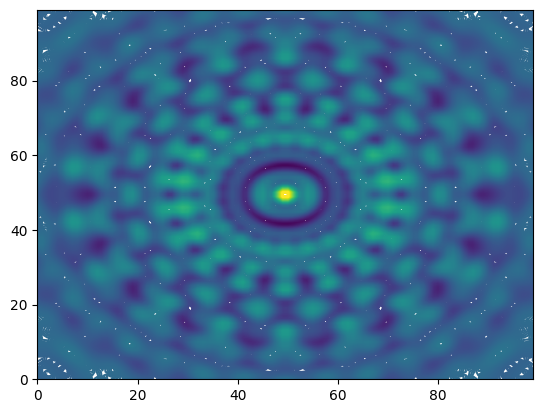

In [45]:
cat_out_mode1and2 = BS(2, N, N, two_mode_cat_begin)
wigner_ = wigner(cat_out_mode1and2, x, p)
plt.contour(wigner_, levels=1000)

So now I have a two-mode squeezed cat state after the beam splitter.

I am assuming the P output is 0, which is a squeezed vacuum state, since our fockspace not can be infinite-dimensional.

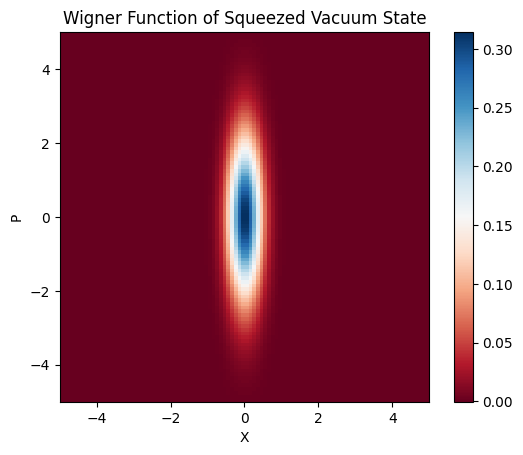

In [76]:
vac = basis(N, 0)
vac_squeezed = squeeze(N, z = np.log(2.2)) * vac.unit()

vac_wigner = wigner(vac_squeezed,x,p)
plt.figure()
plt.imshow(vac_wigner, extent=[-5, 5, -5, 5], cmap='RdBu')
plt.title('Wigner Function of Squeezed Vacuum State')
plt.xlabel('X')
plt.ylabel('P')
plt.colorbar()
plt.show()

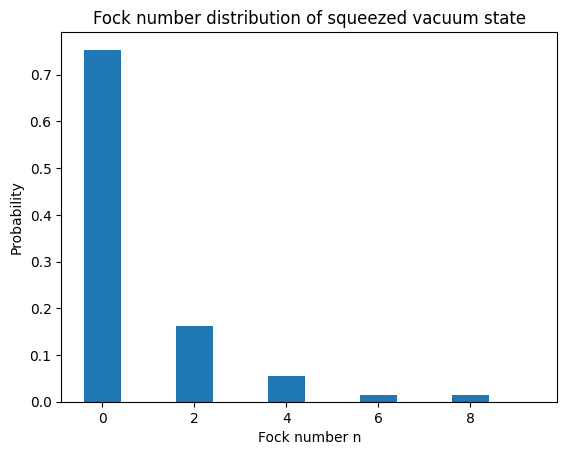

In [47]:
n = np.arange(N)  # Fock numbers
probs = np.abs(vac_squeezed.full())**2  # |<n|psi>|^2
probs = probs.flatten() 
plt.bar(n, probs)
plt.xlabel("Fock number n")
plt.ylabel("Probability")
plt.title("Fock number distribution of squeezed vacuum state")
plt.show()

In [ ]:
vac = basis(N, 0)
vac_squeezed = squeeze(N, z = np.log(2.1)) * vac.unit()
p0_DM =  vac_squeezed * vac_squeezed.dag()
p0_DM_full = tensor(qeye(N), p0_DM)  # expand P0_DM
print(cat_out_mode1and2.shape)
cat_out_mode1and2.shape
projection_of_mode_1 = ( p0_DM_full * cat_out_mode1and2).ptrace(1) # 0 is mode 1, and 1 is mode 2

(100, 100)


In [61]:
def cat_breeding(eta, N ):

    #creating squeezed vacuum density matrix and make it N^2 dimensions
    vac = basis(N, 0)
    vac_squeezed = squeeze(N, z = np.log(2.2)) * vac.unit()
    vac_DM = vac_squeezed * vac_squeezed.dag()
    vac_DM_full = tensor(qeye(N), vac_DM)  # Projector for mode 2

    #creating two-mode cat state
    cat_state = (coherent(N,alpha=1) - coherent(N,alpha=-1)).unit()
    mu = np.sqrt(3/2 * np.pi)
    
    sq = squeeze(N, z = np.log(mu))

    cat_state_squeezed = (sq * cat_state).unit()
    cat_DM = cat_state_squeezed * cat_state_squeezed.dag()

    mode_2_list = []
    current_state_ket = cat_state_squeezed
    current_state_DM = cat_state_squeezed
    cat_out_list = []

    for i in range(len(eta)):
        if current_state_ket.isket:
            # For ket input
            cat_two = tensor(current_state_ket, cat_state_squeezed)
            # For density matrix input
        else:
            cat_two = tensor(current_state_DM, cat_DM)

        cat_out = BS(eta[i],N, N, cat_two)
        cat_out_list.append(cat_out)

        if cat_out.isket:
            # For ket input
            projected = (vac_DM_full * cat_out.proj()).ptrace(1)
        else:
            # For density matrix input
            projected = (vac_DM_full * cat_out).ptrace(1)

        # Update current state and cat_DM for next iteration
        current_state_ket = projected
        current_state_DM = projected

        mode_2_list.append(projected)

    return mode_2_list, cat_out_list


In [62]:
eta_list = np.arange(2,5)

cat_states, cat_out_mode12 = cat_breeding(eta_list, N=10)

wigner_cat = []
wigner_cat12 = []

for i in tqdm(range(len(eta_list)), desc="Computing Wigner functions", unit="iterations"):

        wigner_cat.append(wigner(cat_states[i], x, p))
        wigner_cat12.append(wigner(cat_out_mode12[i], x, p))


Computing Wigner functions:   0%|          | 0/3 [00:00<?, ?iterations/s]

$H_{space} = H_{mode 1} \otimes H_{mode 2} => $ all modes must have $N^2$ dimensions 

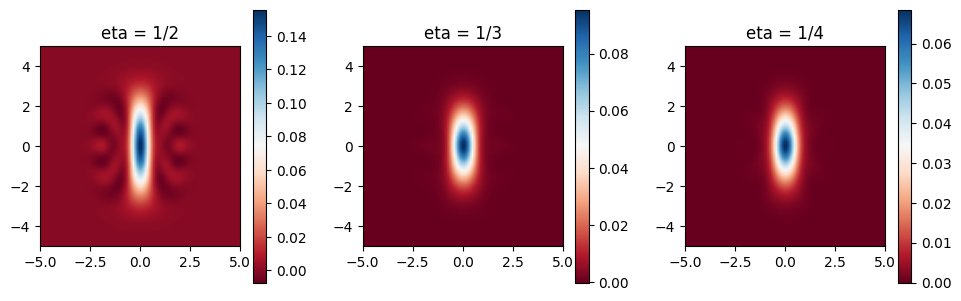

In [63]:
plt.figure(figsize=(16, 12))
for i in range(len(eta_list)):
    plt.subplot(4, 5, i + 1)
    plt.title(f"eta = 1/{eta_list[i]}")
    plt.imshow(wigner_cat[i], extent=[-5, 5, -5, 5], cmap='RdBu')
    plt.colorbar()
plt.tight_layout()
plt.show()


In [ ]:
def cat_breeding(eta_list, N):
    # vacuum projector on mode 2
    vac = basis(N, 0)
    vac_squeezed = squeeze(N, z=np.log(2.2)) * vac

    vac_DM = vac_squeezed * vac_squeezed.dag()

    vac_DM_full = tensor(qeye(N), vac_DM)

    # initial cat state
    cat_state = (coherent(N, alpha=1) - coherent(N, alpha=-1)).unit()
    mu = np.sqrt(3/2 * np.pi)
    sq = squeeze(N, z=np.log(mu))
    cat_state_squeezed = (sq * cat_state).unit()
    cat_DM = cat_state_squeezed * cat_state_squeezed.dag()

    # lists to save states
    mode_2_list = []
    cat_out_list = []

    current_state = cat_DM  # always density matrix

    for t in eta_list:
        # always tensor density matrices
        two_mode = tensor(current_state, cat_DM)

        # apply BS
        cat_out = BS(t, N, N, two_mode)
        cat_out_list.append(cat_out)

        # project mode 1 onto squeezed vacuum
        projected = (vac_DM_full * cat_out * vac_DM_full.dag()).ptrace(0)

        # normalize
        projected = projected / projected.tr()

        # update for next step
        current_state = projected
        mode_2_list.append(projected)

    return mode_2_list, cat_out_list


In [ ]:
eta_list = np.arange(2,4)
cat_states, cat_out_mode12 = cat_breeding(eta_list, N=20)

wigner_cat = []
wigner_cat12 = []

for i in tqdm(range(len(eta_list)), desc="Computing Wigner functions", unit="iterations"):

        wigner_cat.append(wigner(cat_states[i], x, p))


Computing Wigner functions:   0%|          | 0/2 [00:00<?, ?iterations/s]

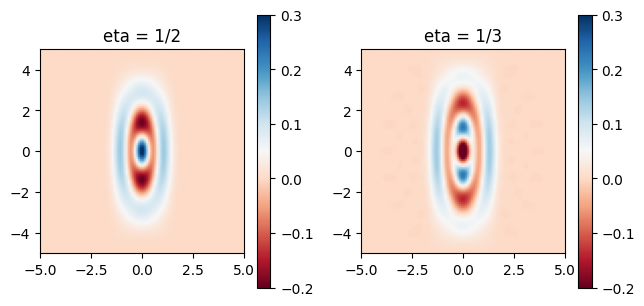

In [70]:
plt.figure(figsize=(16, 12))
for i in range(len(eta_list)):
    plt.subplot(4, 5, i + 1)
    plt.title(f"eta = 1/{eta_list[i]}")
    plt.imshow(wigner_cat[i], extent=[-5, 5, -5, 5], vmin = -0.2, vmax = 0.3, cmap='RdBu')
    plt.colorbar()
plt.tight_layout()
plt.show()



In [53]:
vac = basis(N, 0)
vac_squeezed = squeeze(N, z=np.log(2.2)) * vac
p_values = np.linspace(-0.3,0.3,5)

vac_projectors = []
for p in p_values:
    vac_disp = displace(N, alpha=p) * vac_squeezed
    vac_DM = vac_disp * vac_disp.dag()
    vac_full = tensor(qeye(N), vac_DM)
    vac_projectors.append(vac_full)

#print(vac_projectors[0])
# initial cat state
cat_state = (coherent(N, alpha=1) - coherent(N, alpha=-1)).unit()
mu = np.sqrt(3/2 * np.pi)
sq = squeeze(N, z=np.log(mu))
cat_state_squeezed = (sq * cat_state).unit()
cat_DM = cat_state_squeezed * cat_state_squeezed.dag()


In [54]:
rho_1 = tensor(cat_DM, cat_DM)
rho1_output = BS(2, N, N, rho_1)

p1_list = []
rho_2_list = []
p2_list = []

for i in range(len(vac_projectors)):
    p1 = (vac_projectors[i] * rho_1 * vac_projectors[i].dag()).ptrace(0)
    p1_list.append(p1)
    rho2 = tensor(p1, cat_DM)
    rho2_output = BS(3, N, N, rho2)

    for j in range(len(vac_projectors)):
        p2 = (vac_projectors[j] * rho2_output * vac_projectors[j].dag()).ptrace(0)
        p2_list.append(p2)

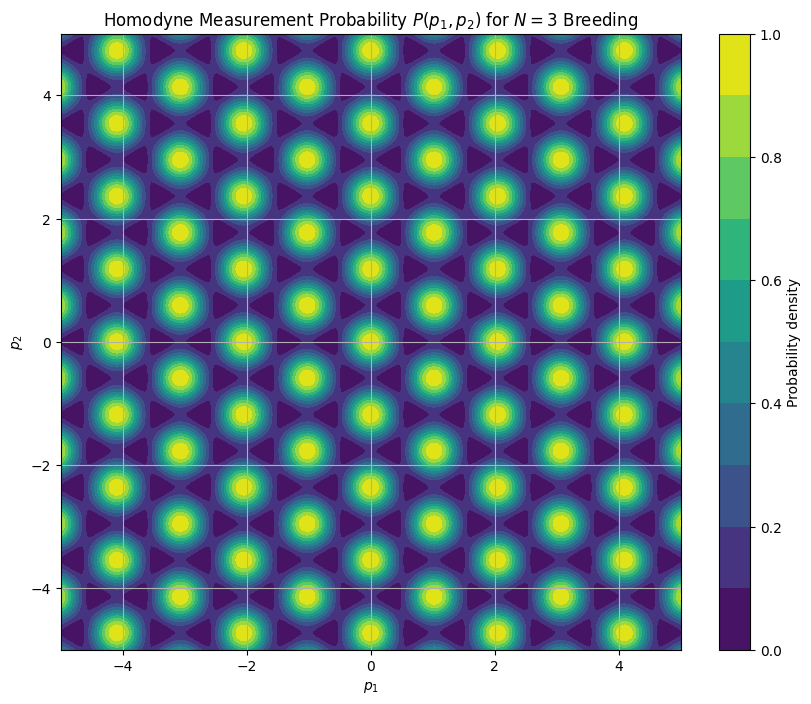

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
hbar = 1
r = 0.2
mu = np.sqrt(3 * np.pi * hbar / 2)  # For qunaught state
sigma_sq = (hbar / 2) * np.exp(2 * r)  # Variance of p-quadrature

p1_range = np.linspace(-5, 5, 200)
p2_range = np.linspace(-5, 5, 200)
P1, P2 = np.meshgrid(p1_range, p2_range)

def f1(p1, p2):
    term1 = 2 * np.exp(1j * mu * np.sqrt(2/3) * p2 / hbar) * np.cos(mu * np.sqrt(2) * p1 / hbar)
    term2 = np.exp(-1j * mu * 2 * np.sqrt(2/3) * p2 / hbar)
    return (term1 + term2) / 3  # Normalized to max=1 at p1=p2=0

F = f1(P1, P2)

F_im = np.imag(F)
F_real = np.real(F)
P = np.abs(F)**2

plt.figure(figsize=(10, 8))
contour = plt.contourf(P1, P2, P, levels=np.linspace(0, 1, 11), cmap='viridis')
plt.colorbar(contour, label='Probability density', ticks=np.linspace(0, 1, 6))
plt.xlabel('$p_1$')
plt.ylabel('$p_2$')
plt.title('Homodyne Measurement Probability $P(p_1, p_2)$ for $N=3$ Breeding')
plt.grid(True)
plt.show()

/Users/liviadarboe/Desktop/A25DTU/Quantum-Information-Science-Project/.venv/lib/python3.13/site-packages/matplotlib/contour.py:1364: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmax = z.max().astype(float)
/Users/liviadarboe/Desktop/A25DTU/Quantum-Information-Science-Project/.venv/lib/python3.13/site-packages/matplotlib/contour.py:1365: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmin = z.min().astype(float)
Locator attempting to generate 1002 ticks ([-0.501, ..., 1.0005000000000002]), which exceeds Locator.MAXTICKS (1000).
/Users/liviadarboe/Desktop/A25DTU/Quantum-Information-Science-Project/.venv/lib/python3.13/site-packages/numpy/ma/core.py:2881: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


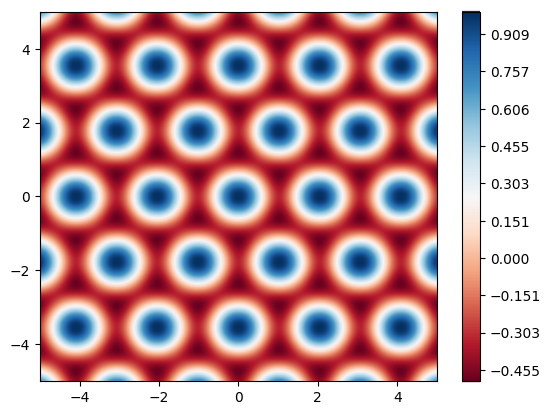

In [97]:
plt.contour(P1, P2, F, levels=1000, cmap='RdBu')
plt.colorbar()

/var/folders/l_/0gbbhqcj6wg0zv6lyz_3rhpc0000gn/T/ipykernel_1459/3535164118.py:24: RuntimeWarning: invalid value encountered in sqrt
  Delta_p = np.sqrt(-2 / (np.abs(alpha)**2) * np.log(np.abs(F)))


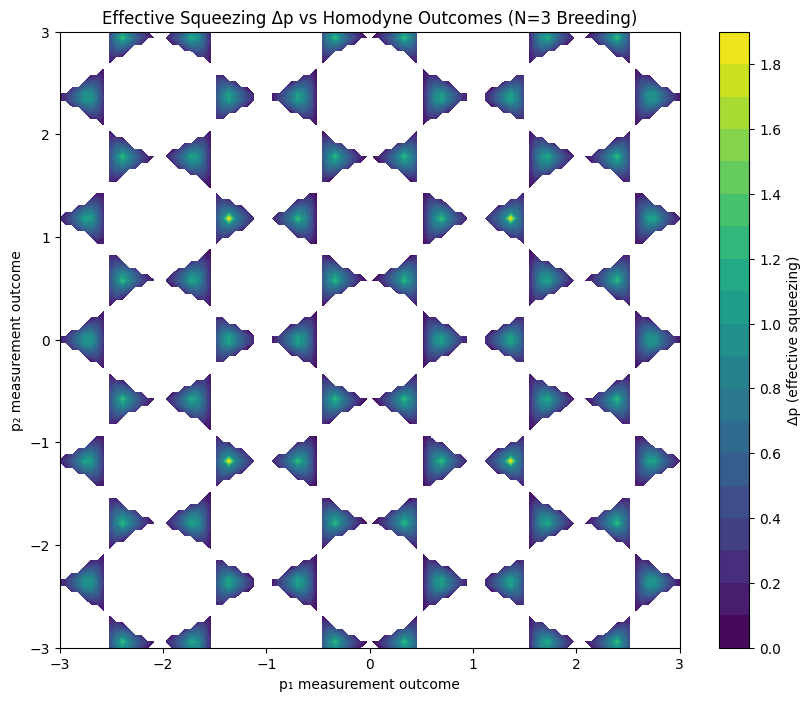

In [72]:
import numpy as np
import matplotlib.pyplot as plt

def f_tilde(mu, p1, p2, hbar=1):
    # Corrected phase factors with proper hbar scaling
    term1 = 2 * np.exp(1j * mu * np.sqrt(2/3) * p2 / hbar) * np.cos(mu * np.sqrt(2) * p1 / hbar)
    term2 = np.exp(-1j * mu * 2 * np.sqrt(2/3) * p2 / hbar)
    return term1 + term2

# Parameters
hbar = 1
mu = np.sqrt(3 * np.pi * hbar / 2)  # For qunaught state (πℏ/2 spacing)

# Measurement range
p1_range = np.linspace(-3, 3, 100)
p2_range = np.linspace(-3, 3, 100)
P1, P2 = np.meshgrid(p1_range, p2_range)

# Compute f_tilde
F = f_tilde(mu, P1, P2)

# Compute Δp (effective squeezing)
alpha = 1j * np.sqrt(np.pi * hbar)  # Stabilizer displacement for qunaught
Delta_p = np.sqrt(-2 / (np.abs(alpha)**2) * np.log(np.abs(F)))

# Plotting
plt.figure(figsize=(10, 8))
contour = plt.contourf(P1, P2, Delta_p, levels=20, cmap='viridis')
plt.colorbar(label='Δp (effective squeezing)')
plt.xlabel('p₁ measurement outcome')
plt.ylabel('p₂ measurement outcome')
plt.title('Effective Squeezing Δp vs Homodyne Outcomes (N=3 Breeding)')
plt.show()